### 1. 定义需要使用到的常量
1. glob 文件名模式匹配，不用遍历整个目录判断每个文件是不是符合。    
    glob.glob('dir/*')#通配符    
    glob.glob('dir/*/*')#用通配符* 代替子目录名    
    glob.glob('dir/file?.txt')#单字符匹配   
    glob.glob('dir/*[0-9].*')#范围匹配    
    

x: ../../datasets/flower_photos ['daisy', 'tulips', 'roses', 'sunflowers', 'dandelion'] 1
x: ../../datasets/flower_photos/daisy [] 633
x: ../../datasets/flower_photos/tulips [] 799
x: ../../datasets/flower_photos/roses [] 641
x: ../../datasets/flower_photos/sunflowers [] 699
x: ../../datasets/flower_photos/dandelion [] 898
sub_dir: ../../datasets/flower_photos/daisy
file_glob: ../../datasets/flower_photos/daisy/*.jpeg 0
file_glob: ../../datasets/flower_photos/daisy/*.JPG 0
file_glob: ../../datasets/flower_photos/daisy/*.JPEG 0
file_glob: ../../datasets/flower_photos/daisy/*.jpg 633
file_list 633


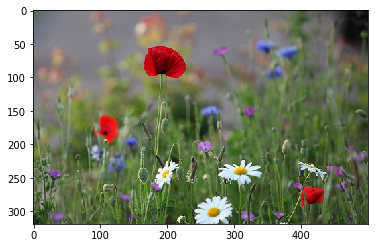

sub_dir: ../../datasets/flower_photos/tulips
file_glob: ../../datasets/flower_photos/tulips/*.jpeg 0
file_glob: ../../datasets/flower_photos/tulips/*.JPG 0
file_glob: ../../datasets/flower_photos/tulips/*.JPEG 0
file_glob: ../../datasets/flower_photos/tulips/*.jpg 799
file_list 799


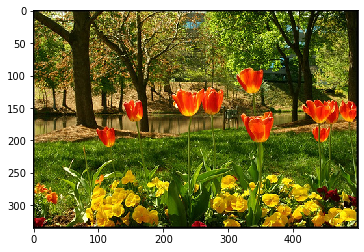

sub_dir: ../../datasets/flower_photos/roses
file_glob: ../../datasets/flower_photos/roses/*.jpeg 0
file_glob: ../../datasets/flower_photos/roses/*.JPG 0
file_glob: ../../datasets/flower_photos/roses/*.JPEG 0
file_glob: ../../datasets/flower_photos/roses/*.jpg 641
file_list 641


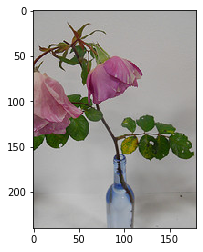

sub_dir: ../../datasets/flower_photos/sunflowers
file_glob: ../../datasets/flower_photos/sunflowers/*.jpeg 0
file_glob: ../../datasets/flower_photos/sunflowers/*.JPG 0
file_glob: ../../datasets/flower_photos/sunflowers/*.JPEG 0
file_glob: ../../datasets/flower_photos/sunflowers/*.jpg 699
file_list 699


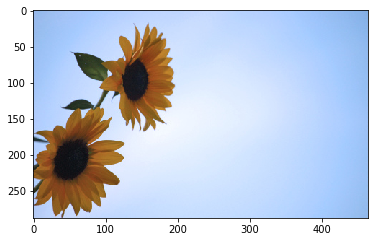

sub_dir: ../../datasets/flower_photos/dandelion
file_glob: ../../datasets/flower_photos/dandelion/*.jpeg 0
file_glob: ../../datasets/flower_photos/dandelion/*.JPG 0
file_glob: ../../datasets/flower_photos/dandelion/*.JPEG 0
file_glob: ../../datasets/flower_photos/dandelion/*.jpg 898
file_list 898


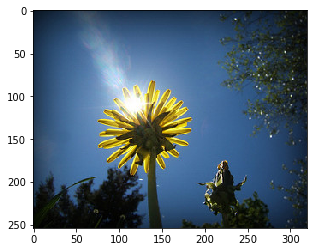

In [51]:
import glob
import os.path
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from PIL import Image

# 原始输入数据的目录，这个目录下有5个子目录，每个子目录底下保存这属于该
# 类别的所有图片。
INPUT_DATA = '../../datasets/flower_photos'
# 输出文件地址。我们将整理后的图片数据通过numpy的格式保存。
OUTPUT_FILE = '../../datasets/flower_processed_data.npy'

# 测试数据和验证数据比例。
VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

sub_dirs = [x[0] for x in os.walk(INPUT_DATA)]
for x in os.walk(INPUT_DATA):
    print("x:",x[0],x[1], len(x[2]))

is_root_dir = True
for sub_dir in sub_dirs:
    if is_root_dir:
        is_root_dir = False
        continue
    print("sub_dir:",sub_dir)
    
    file_list = []
    dir_name = os.path.basename(sub_dir)
    #所有可能的后缀
    extensions = ['jpeg', 'JPG', 'JPEG', 'jpg']
    for extension in extensions:
            file_glob = os.path.join(INPUT_DATA, dir_name, '*.' + extension)
            file_list.extend(glob.glob(file_glob))
            print("file_glob:",file_glob,len(file_list))
            
    #所有后缀都不匹配
    if not file_list: continue
    print("file_list",len(file_list))
    
    i = 0
    # 处理图片数据。
    for file_name in file_list:
        #方法1，tf.image.decode_jpeg, 但是一个op，无法直接看
        #image_raw_data = gfile.FastGFile(file_name, 'rb').read()
        #image = tf.image.decode_jpeg(image_raw_data)
        #方法2，mping,没装pillow的话只支持png
        image_raw_data = mpimg.imread(file_name)
        #image_raw_data = Image.open(file_name)
        if i==0:
            plt.imshow(image_raw_data)
            plt.show()
        i += 1

### 2. 定义数据处理过程

In [6]:
# 读取数据并将数据分割成训练数据、验证数据和测试数据。
def create_image_lists(sess, testing_percentage, validation_percentage):
    sub_dirs = [x[0] for x in os.walk(INPUT_DATA)]
    is_root_dir = True
    
    # 初始化各个数据集。
    training_images = []
    training_labels = []
    testing_images = []
    testing_labels = []
    validation_images = []
    validation_labels = []
    current_label = 0
    print("training_images:", type(training_images))
    
    # 读取所有的子目录。
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue

        # 获取一个子目录中所有的图片文件。
        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
        file_list = []
        dir_name = os.path.basename(sub_dir)
        for extension in extensions:
            file_glob = os.path.join(INPUT_DATA, dir_name, '*.' + extension)
            file_list.extend(glob.glob(file_glob))
        if not file_list: continue
        print("processing:", dir_name)
        
        i = 0
        # 处理图片数据。
        for file_name in file_list:
            i += 1
            # 读取并解析图片，将图片转化为299*299以方便inception-v3模型来处理。
            image_raw_data = gfile.FastGFile(file_name, 'rb').read()
            image = tf.image.decode_jpeg(image_raw_data)
            if image.dtype != tf.float32:
                image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize_images(image, [299, 299])
            image_value = sess.run(image)
            
            # 随机划分数据聚。
            chance = np.random.randint(100)
            if chance < validation_percentage:
                validation_images.append(image_value)
                validation_labels.append(current_label)
            elif chance < (testing_percentage + validation_percentage):
                testing_images.append(image_value)
                testing_labels.append(current_label)
            else:
                training_images.append(image_value)
                training_labels.append(current_label)
            if i % 200 == 0:
                print (i, "images processed.")
        current_label += 1
    
    # 将训练数据随机打乱以获得更好的训练效果。
    state = np.random.get_state()
    np.random.shuffle(training_images)
    np.random.set_state(state)
    np.random.shuffle(training_labels)
    
    return np.asarray([training_images, training_labels,
                       validation_images, validation_labels,
                       testing_images, testing_labels])

### 3. 运行数据处理过程

In [7]:
with tf.Session() as sess:
    processed_data = create_image_lists(sess, TEST_PERCENTAGE, VALIDATION_PERCENTAGE)
    # 通过numpy格式保存处理后的数据。
    np.save(OUTPUT_FILE, processed_data)

training_images: <class 'list'>
processing: daisy
Instructions for updating:
Use tf.gfile.GFile.
200 images processed.
400 images processed.
600 images processed.
processing: tulips
200 images processed.
400 images processed.
600 images processed.
processing: roses
200 images processed.
400 images processed.
600 images processed.
processing: sunflowers
200 images processed.
400 images processed.
600 images processed.
processing: dandelion
200 images processed.
400 images processed.
600 images processed.
800 images processed.


####  tf.sparse_to_dense的用法

```
tf.sparse_to_dense(sparse_indices, output_shape, sparse_values, default_value, name=None)
```
除去name参数用以指定该操作的name，与方法有关的一共四个参数：    
第一个参数sparse_indices：稀疏矩阵中那些个别元素对应的索引值。    

有三种情况：        
     sparse_indices是个数，那么它只能指定一维矩阵的某一个元素    
     sparse_indices是个向量，那么它可以指定一维矩阵的多个元素    
     sparse_indices是个矩阵，那么它可以指定二维矩阵的多个元素    

第二个参数output_shape：输出的稀疏矩阵的shape    
    
第三个参数sparse_values：个别元素的值。    

分为两种情况：    
     sparse_values是个数：所有索引指定的位置都用这个数    
     sparse_values是个向量：输出矩阵的某一行向量里某一行对应的数（所以这里向量的长度应该和输出矩阵的行数对应，不然报错）    

第四个参数default_value：未指定元素的默认值，一般如果是稀疏矩阵的话就是0了    
    

举一个例子：    
    
在mnist里面有一个把数字标签转化成onehot标签的操作，所谓onehot标签就是：    

如果标签是6那么对应onehot就是[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
如果标签是1那么对应onehot就是[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
如果标签是0那么对应onehot就是[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

就是把标签变为适用于神经网络输出的形式。
BATCHSIZE=6     
label=tf.expand_dims(tf.constant([0,2,3,6,7,9]),1)    
假设一个batch有6个样本，每个样本的label是0，2，3，6，7，9    
index=tf.expand_dims(tf.range(0, BATCHSIZE),1)    
生成一个index表明一个batch里面每个样本对应的序号    
(至于这里为什么要调用tf.expand_dims我在上一篇博客已经解释过了，链接：      http://blog.csdn.net/mao_xiao_feng/article/details/53366163)    
    
concated = tf.concat(1, [index, label])    
最后把他们两个矩阵进行连接，连接以后的矩阵是这样的   
```
[[0 0]
 [1 2]
 [2 3]
 [3 6]
 [4 7]
 [5 9]]
```
onehot_labels = tf.sparse_to_dense(concated, tf.pack([BATCHSIZE,10]), 1.0, 0.0)
最后一步，调用tf.sparse_to_dense输出一个onehot标签的矩阵，输出的shape就是行数为BATCHSIZE，列数为10的矩阵，指定元素值为1.0，其余元素值为0.0    

In [7]:
import tensorflow as tf
import numpy

BATCHSIZE=6
label=tf.expand_dims(tf.constant([0,2,3,6,7,9]),1)
index=tf.expand_dims(tf.range(0, BATCHSIZE),1)
#use a matrix
concated = tf.concat([index, label],1)
stack=tf.stack([BATCHSIZE,10])
onehot_labels = tf.sparse_to_dense(concated, tf.stack([BATCHSIZE,10]), 1.0, 0.0)
 
#use a vector
concated2=tf.constant([1,3,4])
#onehot_labels2 = tf.sparse_to_dense(concated2, tf.pack([BATCHSIZE,10]), 1.0, 0.0)#cant use ,because output_shape is not a vector
onehot_labels2 = tf.sparse_to_dense(concated2, tf.stack([10]), 1.0, 0.0)#can use
 
#use a scalar
concated3=tf.constant(5)
onehot_labels3 = tf.sparse_to_dense(concated3, tf.stack([10]), 1.0, 0.0)
 
with tf.Session() as sess:
    print("label:",sess.run(label))
    print("index:",sess.run(index))
    print("concated:",sess.run(concated))
    print("stack:",sess.run(stack))
    result1=sess.run(onehot_labels)
    result2 = sess.run(onehot_labels2)
    result3 = sess.run(onehot_labels3)
    print ("This is result1:")
    print (result1)
    print ("This is result2:")
    print (result2)
    print ("This is result3:")
    print (result3)

label: [[0]
 [2]
 [3]
 [6]
 [7]
 [9]]
index: [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
concated: [[0 0]
 [1 2]
 [2 3]
 [3 6]
 [4 7]
 [5 9]]
stack: [ 6 10]
This is result1:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
This is result2:
[0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
This is result3:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
